## CalMS21 ALL train trials using 5 states 

In [1]:
from bbvi_infer_2lB import * 
from calms import *
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in data observations

In [2]:
input_name = '/data/calms_task1/calms21_task1_train.json'
with open(input_name, 'r') as fp:
    input_data = json.load(fp)
data = convert_to_array(input_data)

In [3]:
## Observations
scaler, trials = fit_scaler(data, np.arange(1, 71))

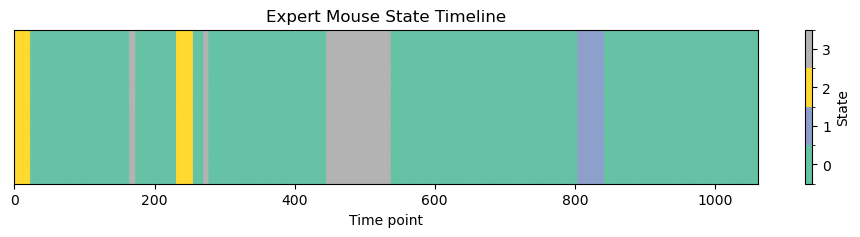

In [13]:
## States 
states = data['annotator-id_0']['task1/train/mouse034_task1_annotator1']['annotations']
plot_expert(states)

In [12]:
torch.mean(zs, dim=0)[0].shape

torch.Size([4879, 5])

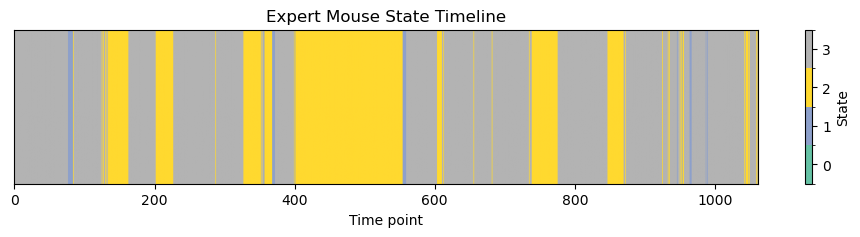

In [14]:
ys_tensor = pad_collate([trials[33]])[0].to(device).float()  # [1,T,N]
zs = variational_z.sample_q_z(ys_tensor.unsqueeze(0).expand(20, -1, -1, -1), temperature=0.99)  # [M,1,T,K]
states_gsd = torch.mean(zs, dim=0)[0].detach().cpu().numpy()
plot_expert(states_gsd.argmax(axis=1))

In [4]:
K=5 ## state
D=3 ## latent dimension

## GSD
### GSD Train

In [6]:
model = GenerativeSLDS(N=28, K=K, D=D, emission_model="gaussian")
elbos, variational_z = fit_bbvi_schedule(model.to('cuda'), trials= trials, 
                                         num_iters=4000, learning=True, n_samples=10, base_lr=1e-2, 
                                         warmup_iters=200, tau_max=0.99, batch_size=35, verbose=False)

ELBO: -129071.0, LR: 0.01000, Tau: 0.990:   2%|▏         | 99/4000 [01:56<1:15:54,  1.17s/it]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: -120614.3, LR: 0.00100, Tau: 0.990:  14%|█▍        | 573/4000 [11:13<1:07:10,  1.18s/it]

Early stopping at iteration 573.


In [8]:
import pickle
with open('./saved_models/calmsGSD.pkl', 'wb') as file:
    pickle.dump([model, variational_z, elbos], file)

Text(0, 0.5, 'ELBO')

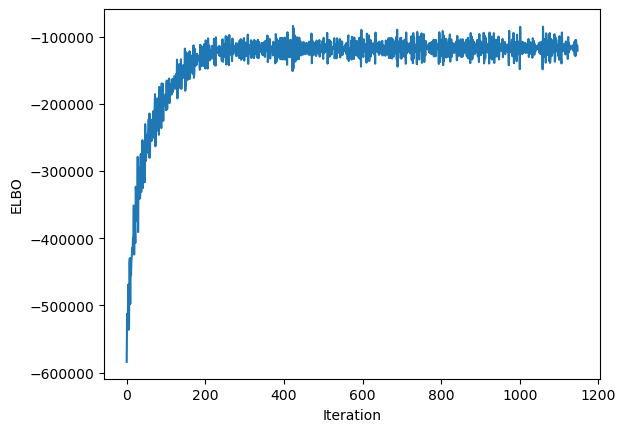

In [7]:
plt.figure()
plt.plot(elbos[0:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

### GSD Training performance

In [5]:
import pickle
with open('./saved_models/calmsGSD.pkl', 'rb') as file:
    model, variational_z, elbos = pickle.load(file)

In [8]:
device = next(model.parameters()).device
n_mc = 20
k_max = 0

all_r2_scores = []
for trial in trials:   # trial: [T,N] tensor
    ys_tensor = pad_collate([trial])[0].to(device).float()  # [1,T,N]

    # Sample latent states
    zs = variational_z.sample_q_z(
        ys_tensor.unsqueeze(0).expand(n_mc, -1, -1, -1), temperature=0.99)  # [M,1,T,K]

    # Smoothed prediction
    pred_ys0 = (model.smooth(ys_tensor, zs).mean(dim=0).detach().cpu().numpy())  # [1,T,N]
    # Compute per-trial R²
    r2_per_trial = train_metrics(ys_tensor, pred_ys0, None, k_max=k_max)
    all_r2_scores.append(r2_per_trial)
print(f"Collected train R² for {len(all_r2_scores)} trials")

Collected train R² for 70 trials


In [9]:
all_r2_scores

[[0.8410120606422424],
 [0.828220009803772],
 [0.8686522245407104],
 [0.8291841149330139],
 [0.8377971649169922],
 [0.853184700012207],
 [0.8703394532203674],
 [0.8322228193283081],
 [0.8393699526786804],
 [0.8439553380012512],
 [0.8395323157310486],
 [0.8391055464744568],
 [0.7463293075561523],
 [0.7886276245117188],
 [0.8267669081687927],
 [0.8685689568519592],
 [0.7629507184028625],
 [0.8285419344902039],
 [0.7326488494873047],
 [0.7120680212974548],
 [0.8574686646461487],
 [0.6972506642341614],
 [0.807923436164856],
 [0.8089934587478638],
 [0.8407450318336487],
 [0.7790958285331726],
 [-0.21224398910999298],
 [0.8337806463241577],
 [0.8433671593666077],
 [0.8734426498413086],
 [0.8568004369735718],
 [0.8734270930290222],
 [0.7806859612464905],
 [0.7593705058097839],
 [0.8162354230880737],
 [0.28738051652908325],
 [0.42186683416366577],
 [0.8425363302230835],
 [0.831320583820343],
 [-1.7722301483154297],
 [0.5803242921829224],
 [0.7941185832023621],
 [0.7192732691764832],
 [0.804912

### GSD Test performance
For test, we feed in the test dataset in CalMS21.

In [10]:
input_name = '/data/calms_task1/calms21_task1_test.json'
with open(input_name, 'r') as fp:
    input_data = json.load(fp)
data_test = convert_to_array(input_data)

In [15]:
def transform_scaler(data, scaler, mouse_ids, annotator="annotator-id_0", task="task1/test"):
    trials = []  
    # transform each trial
    for mid in mouse_ids:
        key = f"{task}/mouse{mid:03d}_{task.split('/')[0]}_annotator1"
        kp = data[annotator][key]['keypoints']
        kp_norm = normalize_by_image(kp, W, H)
        X = kp_norm.reshape(kp_norm.shape[0], -1)
        X_scaled = scaler.transform(X)
        trials.append(torch.tensor(X_scaled).to('cuda').float())
    return trials

In [17]:
trials_test = transform_scaler(data_test, scaler, np.arange(71, 90))

In [18]:
device = next(model.parameters()).device
n_mc = 20
k_max = 0

all_r2_scores1 = []
for trial in trials_test:   # trial: [T,N] tensor
    ys_tensor = pad_collate([trial])[0].to(device).float()  # [1,T,N]

    # Sample latent states
    zs = variational_z.sample_q_z(
        ys_tensor.unsqueeze(0).expand(n_mc, -1, -1, -1), temperature=0.99)  # [M,1,T,K]

    # Smoothed prediction
    pred_ys0 = (model.smooth(ys_tensor, zs).mean(dim=0).detach().cpu().numpy())  # [1,T,N]
    # Compute per-trial R²
    r2_per_trial = train_metrics(ys_tensor, pred_ys0, None, k_max=k_max)
    all_r2_scores1.append(r2_per_trial)
print(f"Collected test R² for {len(all_r2_scores1)} trials")

Collected test R² for 19 trials


In [19]:
all_r2_scores1

[[0.8520662188529968],
 [0.8067931532859802],
 [0.8598607182502747],
 [0.8378812670707703],
 [0.7610061764717102],
 [0.8453954458236694],
 [0.8530036211013794],
 [0.8422971367835999],
 [0.9008356928825378],
 [0.7604917287826538],
 [0.8039278388023376],
 [0.8180524110794067],
 [0.8314289450645447],
 [0.8669986128807068],
 [0.8758424520492554],
 [0.8612979650497437],
 [0.8519564867019653],
 [0.8566097021102905],
 [0.8279854655265808]]

### State Quality  

In [30]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_state_quality(trials_train, trials_test, data, data_test, train_ids, test_ids,
                           model, variational_z, n_mc=20, temperature=0.99, n_neighbors=10, device="cuda"):
    # ---------- TRAIN ----------
    Z_train_list, Y_train_list = [], []
    for trial, trial_id in zip(trials_train, train_ids):
        ys_tensor = pad_collate([trial])[0].to(device).float()  # [1,T,N]

        # Sample latent states
        zs = variational_z.sample_q_z(
            ys_tensor.unsqueeze(0).expand(n_mc, -1, -1, -1), temperature
        )  # [M,1,T,K]

        # Average across M and drop batch
        Z_trial = torch.mean(zs, dim=0)[0].detach().cpu().numpy()  # [T,K]
        Y_trial = np.asarray(data['annotator-id_0'][trial_id]['annotations'])

        Z_train_list.append(Z_trial)
        Y_train_list.append(Y_trial)

    Z_train = np.vstack(Z_train_list)
    Y_train = np.concatenate(Y_train_list)

    # ---------- TEST ----------
    Z_test_list, Y_test_list = [], []
    per_trial_scores = []
    for trial, trial_id in zip(trials_test, test_ids):
        ys_tensor = pad_collate([trial])[0].to(device).float()
        zs = variational_z.sample_q_z(
            ys_tensor.unsqueeze(0).expand(n_mc, -1, -1, -1), temperature)  # [M,1,T,K]

        Z_trial = torch.mean(zs, dim=0)[0].detach().cpu().numpy()
        Y_trial = np.asarray(data_test['annotator-id_0'][trial_id]['annotations'])

        Z_test_list.append(Z_trial)
        Y_test_list.append(Y_trial)

    Z_test = np.vstack(Z_test_list)
    Y_test = np.concatenate(Y_test_list)
    # ---------- KNN ----------
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc_train = knn.score(Z_train, Y_train)
    acc_test = knn.score(Z_test, Y_test)

    # Per-test-trial accuracy
    for Z_trial, Y_trial, trial_id in zip(Z_test_list, Y_test_list, test_ids):
        acc_trial = knn.score(Z_trial, Y_trial)
        per_trial_scores.append(acc_trial)

    print("Train accuracy:", acc_train)
    print("Test accuracy (all pooled):", acc_test)
    return acc_train, acc_test, per_trial_scores

In [31]:
train_ids = [f"task1/train/mouse{str(i).zfill(3)}_task1_annotator1" for i in range(1, 71)]
test_ids  = [f"task1/test/mouse{str(i).zfill(3)}_task1_annotator1" for i in range(71, 90)]

acc_train, acc_test, per_trial_scores = evaluate_state_quality(
    trials, trials_test, data, data_test,
    train_ids, test_ids,
    model, variational_z,
    n_mc=20, temperature=0.99, n_neighbors=10)

Train accuracy: 0.7091590544729762
Test accuracy (all pooled): 0.5919147523721229


In [32]:
per_trial_scores

[0.6596808063838723,
 0.45105703589517726,
 0.46491960743370225,
 0.6223107569721116,
 0.7163474882042742,
 0.5796042617960426,
 0.7229597503570107,
 0.5209264109279516,
 0.6398787393467941,
 0.5466904029778281,
 0.7033657745336578,
 0.60646521433591,
 0.6156525302192174,
 0.6482403128332741,
 0.49020833333333336,
 0.5007543228501798,
 0.6613512379353755,
 0.6058923512747876,
 0.57894270001774]

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
train_ids = [f"task1/train/mouse{str(i).zfill(3)}_task1_annotator1" for i in range(1, 71)]
for trial, trial_id in zip(trials, train_ids):
    ys_tensor = pad_collate([trial])[0].to(device).float()  # [1,T,N]
    # Sample latent states
    zs = variational_z.sample_q_z(
        ys_tensor.unsqueeze(0).expand(20, -1, -1, -1), temperature=0.99)  # [M,1,T,K]
    Z_train = torch.mean(zs, dim=0)[0].detach().cpu().numpy()
    np.asarray(data['annotator-id_0'][trial_id]['annotations'])
    Y_train = np.asarray(data['annotator-id_0'][trial_id]['annotations'])
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc1 = knn.score(Z_train, Y_train)
    print(f"Train accuracy for {trial_id}:", acc1)

Train accuracy for task1/train/mouse001_task1_annotator1: 0.7517786931286276
Train accuracy for task1/train/mouse002_task1_annotator1: 0.7879853176859846
Train accuracy for task1/train/mouse003_task1_annotator1: 0.811450612615338
Train accuracy for task1/train/mouse004_task1_annotator1: 0.8713843670119736
Train accuracy for task1/train/mouse005_task1_annotator1: 0.8993086332210601
Train accuracy for task1/train/mouse006_task1_annotator1: 0.7507428194123473
Train accuracy for task1/train/mouse007_task1_annotator1: 0.8085785536159601
Train accuracy for task1/train/mouse008_task1_annotator1: 0.7771543788901552
Train accuracy for task1/train/mouse009_task1_annotator1: 0.8246519443110898
Train accuracy for task1/train/mouse010_task1_annotator1: 0.8415647357489038
Train accuracy for task1/train/mouse011_task1_annotator1: 0.8488262910798122
Train accuracy for task1/train/mouse012_task1_annotator1: 0.8228094575799721
Train accuracy for task1/train/mouse013_task1_annotator1: 0.9244365885992046


### Visualization of accuracy

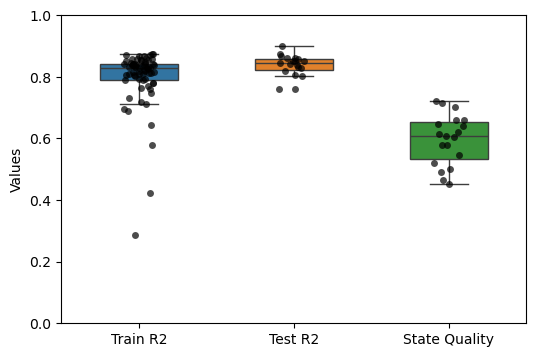

In [37]:
import seaborn as sns
# Combine into a dataframe-friendly format
data = [[x[0] for x in all_r2_scores], [x[0] for x in all_r2_scores1], per_trial_scores]
labels = ["Train R2", "Test R2", "State Quality"]

# Plot
plt.figure(figsize=(6,4))
sns.boxplot(data=data, width=0.5, showfliers=False)
sns.stripplot(data=data, color="black", size=5, jitter=True, alpha=0.7)

plt.xticks(range(3), labels)
plt.ylabel("Values")
plt.title("")
plt.ylim(0, 1)  # since all values in [0,1]
plt.show()